# Masked Fitting Deblender

Owner: **Bryce Kalmbach** ([@jbkalmbach](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@jbkalmbach)) <br>
Last Verified to Run: 2022-12-08 <br>
Software Versions:
  - `ts_wep`: **v4.0.0**
  - `ts_phosim`: **v2.0.3**
  - `lsst_distrib`: **w_2022_50**

## Notebook Objective:

In this notebook we will introduce the masked fitting deblender added to `ts_wep` in v4.0.0 and analyze the range of validity of its application.

## Logistics

This notebook is meant to be run on the Rubin USDF notebook portal: https://usdf-rsp.slac.stanford.edu/.

## Imports

In [1]:
import os
from lsst.daf.butler import Butler
from lsst.afw import image as afwImage

from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import runProgram, writePipetaskCmd, getConfigDir, CamType, DefocalType
from lsst.ts.wep.task.GenerateDonutCatalogWcsTask import GenerateDonutCatalogWcsTaskConfig, GenerateDonutCatalogWcsTask
from lsst.ts.wep.task.CutOutDonutsCwfsTask import (
    CutOutDonutsCwfsTask, 
    CutOutDonutsCwfsTaskConfig
)
from lsst.ts.wep.task.CutOutDonutsScienceSensorTask import (
    CutOutDonutsScienceSensorTask, 
    CutOutDonutsScienceSensorTaskConfig
)
from lsst.ts.wep.task.CalcZernikesTask import CalcZernikesTask, CalcZernikesTaskConfig

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import rotate, shift, binary_dilation
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Load data

In [2]:
butler_repo = 'testData/donutDeblending/comcam_0066/phosimData'

In [3]:
butler = Butler(butler_repo)

In [4]:
dataIdExtra = {
    'instrument': 'LSSTComCam', 
    'detector': 4, 
    'exposure': 4021123106001,
    'visit': 4021123106001
}
dataIdIntra = {
    'instrument': 'LSSTComCam', 
    'detector': 4, 
    'exposure': 4021123106002,
    'visit': 4021123106002
}
postIsrExtra = butler.get('postISRCCD', dataId=dataIdExtra, collections='ts_phosim_9006001')
postIsrIntra = butler.get('postISRCCD', dataId=dataIdIntra, collections='ts_phosim_9006001')
camera = butler.get('camera', instrument='LSSTComCam', collections='LSSTComCam/calib/unbounded')

## Updated Source Selection

As part of the update to add masked blending into the `ts_wep` code we added and changed some parameters involved in donut source selection.

### Source selection configuration

In [5]:
# Initialize Configuration
donutCatConfig = GenerateDonutCatalogWcsTaskConfig()

In [6]:
# Activate the subtask
donutCatConfig.doDonutSelection = True

In [7]:
# Set the unblended separation distance
donutCatConfig.donutSelector.unblendedSeparation = 160

![source_selector_figure 1](notebook_figures/selector_figure_1.jpg)

In [8]:
# Set the magnitude difference for stars to count as not blended with fainter, overlapping stars
donutCatConfig.donutSelector.isolatedMagDiff = 2.0

![source_selector_figure 1](notebook_figures/selector_figure_2.jpg)

In [9]:
# Set the blended separation distance
donutCatConfig.donutSelector.minBlendedSeparation = 80

![source_selector_figure 1](notebook_figures/selector_figure_3.jpg)

In [10]:
# Set the number of stars that can be blended with a star. A value of 0 here means we only take unblended stars.
donutCatConfig.donutSelector.maxBlended = 1

![source_selector_figure 1](notebook_figures/selector_figure_4.jpg)

In [11]:
# Set source limit (-1 means all sources that pass filtering).
donutCatConfig.donutSelector.sourceLimit = -1

### Run the donut catalog generation task

In [12]:
catCreationTask = GenerateDonutCatalogWcsTask(config=donutCatConfig)

In [13]:
butler.registry.queryCollections()

['refcats',
 'LSSTComCam/raw/all',
 'LSSTComCam/calib',
 'LSSTComCam/calib/unbounded',
 'ts_phosim_9006001',
 'ts_phosim_9006011',
 'ts_phosim_9006021',
 'ts_phosim_9006031',
 'ts_phosim_9006041',
 'ts_phosim_9006051']

In [14]:
refCats = []
for refCatRef in butler.registry.queryDatasets('cal_ref_cat', collections='refcats').expanded():
    refCats.append(butler.getDeferred(refCatRef, collections='refcats'))

In [15]:
donutCatalogExtra = catCreationTask.run(refCats, postIsrExtra).donutCatalog

In [16]:
donutCatalogIntra = catCreationTask.run(refCats, postIsrIntra).donutCatalog

The donut catalogs now have an additional two columns (`blend_centroid_x` and `blend_centroid_y`) containing information on the locations of any blended objects.

In [17]:
donutCatalogExtra

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,0.0,0.0,2036.5,2000.5,3.630781e+06,[2102.75800039397],[2099.104000300506]


In [18]:
donutCatalogIntra

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,0.0,0.0,2036.5,2000.5,3.630781e+06,[2102.75800039397],[2099.104000300506]


## Generate DonutStamps with masked blending

Text(0.5, 1.0, 'PostISR Exposure')

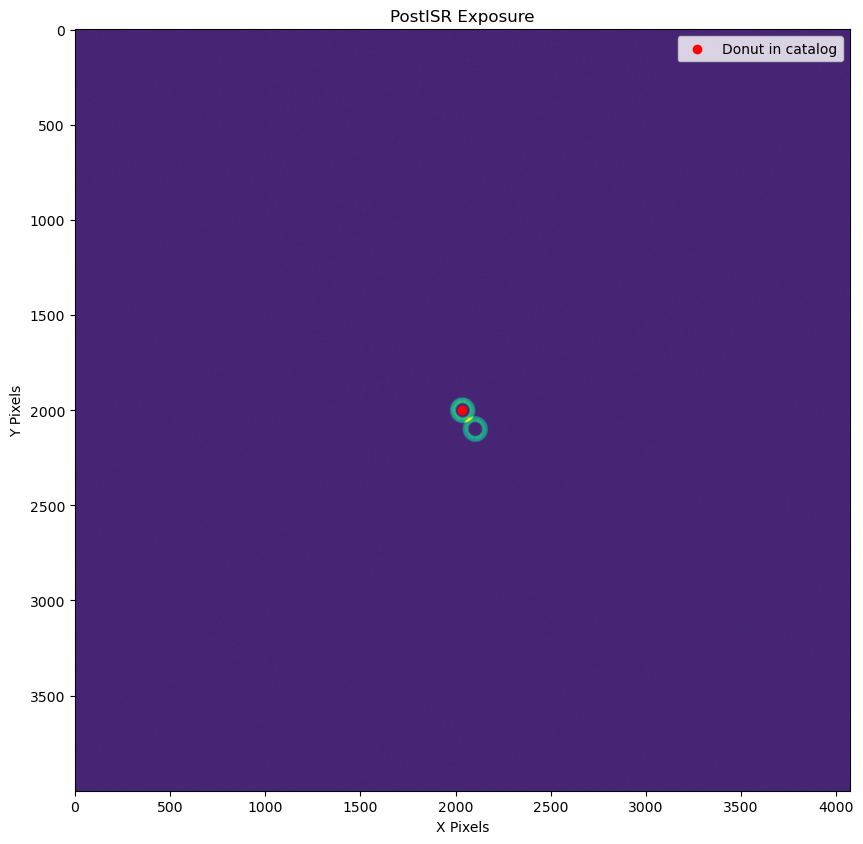

In [19]:
fig = plt.figure(figsize=(10,10))
plt.imshow(postIsrExtra.getImage().getArray(), vmax=500)
plt.scatter(donutCatalogExtra['centroid_x'], donutCatalogExtra['centroid_y'], c='r', label='Donut in catalog')
plt.legend()
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.title('PostISR Exposure')

Show original cutout from exposure

Text(0.5, 1.0, 'PostISR Exposure')

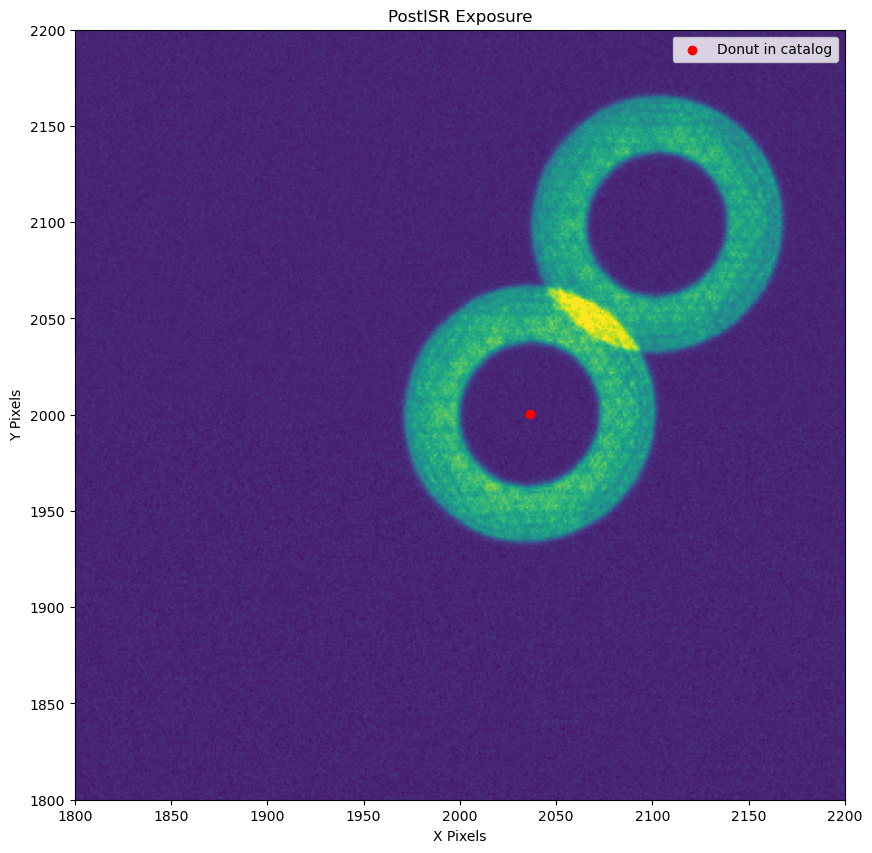

In [20]:
fig = plt.figure(figsize=(10,10))
plt.imshow(postIsrExtra.getImage().getArray(), vmax=500)
plt.scatter(donutCatalogExtra['centroid_x'], donutCatalogExtra['centroid_y'], c='r', label='Donut in catalog')
plt.xlim((1800, 2200))
plt.ylim((1800, 2200))
plt.legend()
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.title('PostISR Exposure')

Run donut stamp with new masking turned off

In [21]:
cutOutDonutsTask = CutOutDonutsScienceSensorTask()

In [22]:
donutStamps = cutOutDonutsTask.run(
    [postIsrExtra, postIsrIntra], [donutCatalogExtra, donutCatalogIntra], camera
)
donutStampsExtra = donutStamps.donutStampsExtra
donutStampsIntra = donutStamps.donutStampsIntra

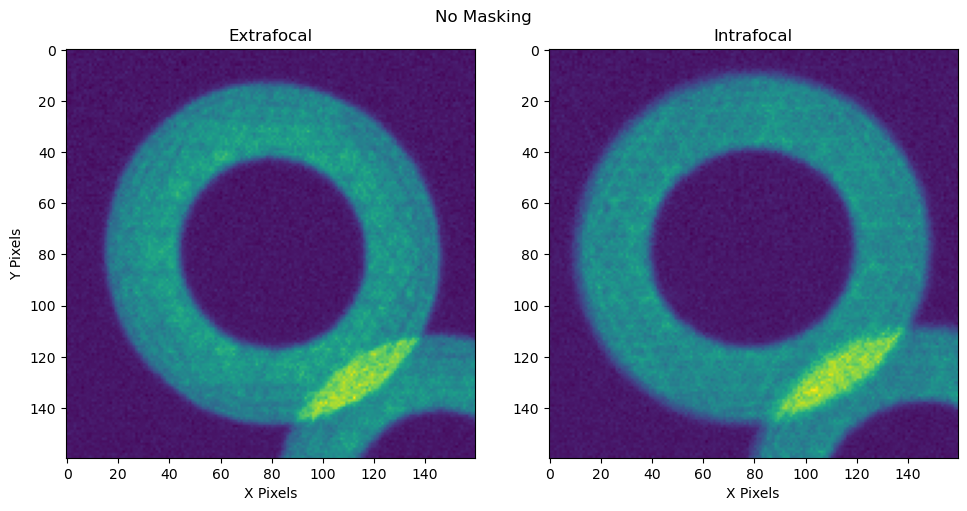

In [23]:
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1,2,1)
plt.imshow(donutStampsExtra[0].stamp_im.getImage().getArray())
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.title('Extrafocal')
fig.add_subplot(1,2,2)
plt.imshow(donutStampsIntra[0].stamp_im.getImage().getArray())
plt.xlabel('X Pixels')
plt.title('Intrafocal')
plt.suptitle('No Masking')
plt.tight_layout()

Then turn on setting and show donut stamp that has mask included.

New configurations:

* `multiplyMask`: Turn on/off masking in donutStamps.

* `maskGrowthIter`: Number of iterations to run binary dilation to grow mask.

In [24]:
cutOutDonutsWithMaskConfig = CutOutDonutsScienceSensorTaskConfig(
    multiplyMask=True, 
    maskGrowthIter=6
)

In [25]:
cutOutDonutsWithMaskConfig

lsst.ts.wep.task.CutOutDonutsScienceSensorTask.CutOutDonutsScienceSensorTaskConfig(saveMetadata=True, saveLogOutput=True, donutTemplateSize=160, donutStampSize=160, initialCutoutPadding=5, opticalModel='offAxis', instObscuration=0.61, instFocalLength=10.312, instApertureDiameter=8.36, instPixelSize=1e-05, multiplyMask=True, maskGrowthIter=6, connections={'exposures': 'postISRCCD', 'donutCatalog': 'donutCatalog', 'camera': 'camera', 'donutStampsExtra': 'donutStampsExtra', 'donutStampsIntra': 'donutStampsIntra'})

In [26]:
cutOutDonutsWithMaskTask = CutOutDonutsScienceSensorTask(config=cutOutDonutsWithMaskConfig)

In [27]:
postIsrExtra = butler.get('postISRCCD', dataId=dataIdExtra, collections='ts_phosim_9006001')
postIsrIntra = butler.get('postISRCCD', dataId=dataIdIntra, collections='ts_phosim_9006001')

In [28]:
donutStampsWithMask = cutOutDonutsWithMaskTask.run(
    [postIsrExtra, postIsrIntra], [donutCatalogExtra, donutCatalogIntra], camera
)
donutStampsExtraWM = donutStampsWithMask.donutStampsExtra
donutStampsIntraWM = donutStampsWithMask.donutStampsIntra

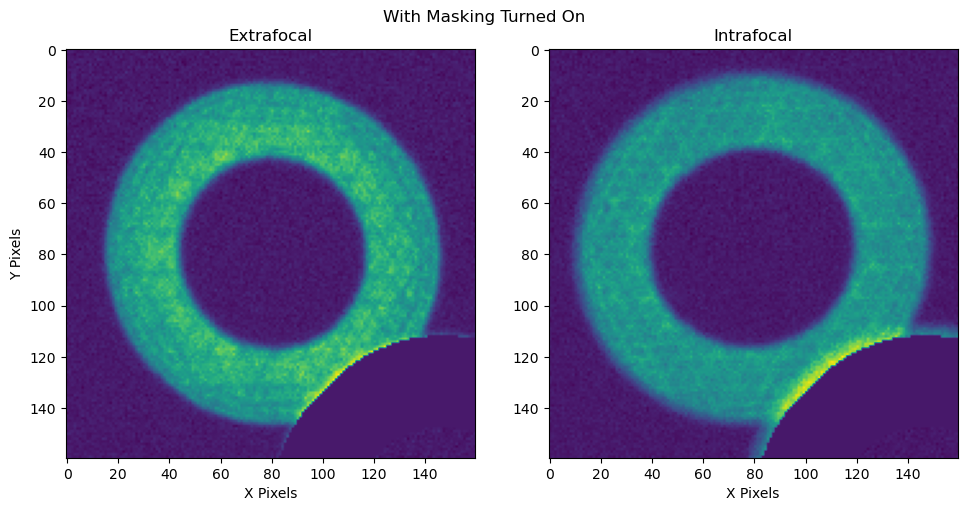

In [29]:
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1,2,1)
plt.imshow(donutStampsExtraWM[0].stamp_im.getImage().getArray())
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.title('Extrafocal')
fig.add_subplot(1,2,2)
plt.imshow(donutStampsIntraWM[0].stamp_im.getImage().getArray())
plt.xlabel('X Pixels')
plt.title('Intrafocal')
plt.suptitle('With Masking Turned On')
plt.tight_layout()

## Running the calcZernikes task

This task runs identically as before. The real changes are in the algorithm under the hood.

In [30]:
calcZernConfig = CalcZernikesTaskConfig()

In [31]:
calcZernTask = CalcZernikesTask(config=calcZernConfig)

In [32]:
unMaskedZernikes = calcZernTask.run(donutStampsExtra, donutStampsIntra)
maskedZernikes = calcZernTask.run(donutStampsExtraWM, donutStampsIntraWM)

In [33]:
opd_truth = np.genfromtxt('testData/donutDeblending/comcam_0066/iter0/img/opd.zer')

Text(0.5, 1.0, 'Comparing Masked vs. Unmasked Donut Stamps')

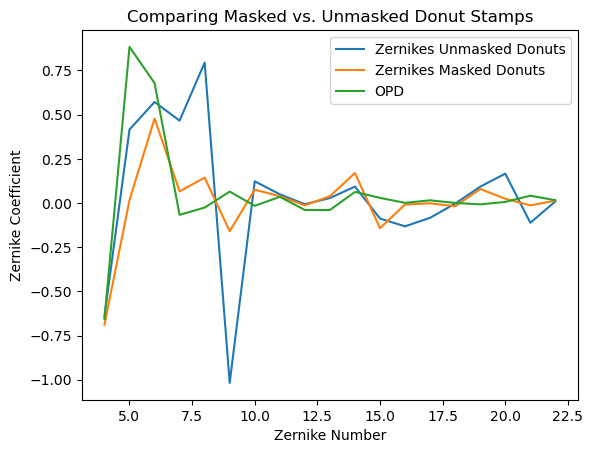

In [34]:
plt.plot(np.arange(4,23),unMaskedZernikes.outputZernikesAvg, label='Zernikes Unmasked Donuts')
plt.plot(np.arange(4,23), maskedZernikes.outputZernikesAvg, label='Zernikes Masked Donuts')
plt.plot(np.arange(4,23), opd_truth[4], label='OPD')
plt.legend()
plt.xlabel('Zernike Number')
plt.ylabel('Zernike Coefficient')
plt.title('Comparing Masked vs. Unmasked Donut Stamps')

## Look inside the algorithm

### Setup for algorithm

In [35]:
# CWFS config
cwfsConfigDir = os.path.join(getConfigDir(), "cwfs")

inst = Instrument()
instConfigDict = {
    # Obscuration (inner_radius / outer_radius of M1M3)
    "obscuration": 0.61,
    # Focal length in m
    "focalLength": 10.312,
    # Aperture diameter in m
    "apertureDiameter": 8.36,
    # Defocal distance offset in mm
    "offset": 1.5,
    # Camera pixel size in m
    "pixelSize": 10.0e-6,
}
inst.configFromDict(instConfigDict, 160, CamType.LsstCam,)

algoDir = os.path.join(cwfsConfigDir, "algo")
expAlgo = Algorithm(algoDir)
expAlgo.config("exp", inst, debugLevel=3)          

In [36]:
intra_img = CompensableImage()
extra_img = CompensableImage()

Compensable images now accept information on the locations of blended objects with the `blendCenters` input parameter.

In [37]:
blendCentersIntra = (
    donutStampsIntraWM[0].blend_centroid_positions - donutStampsIntraWM[0].centroid_position
)
blendCentersIntra = blendCentersIntra.T[::-1]

intra_img.setImg(
    donutStampsIntraWM[0].calcFieldXY(), 
    DefocalType.Intra,
    blendOffsets=blendCentersIntra,
    image=donutStampsIntraWM[0].stamp_im.getImage().getArray().T
)

In [38]:
blendCentersExtra = (
    donutStampsExtraWM[0].blend_centroid_positions - donutStampsExtraWM[0].centroid_position
)
blendCentersExtra = blendCentersExtra.T[::-1]

extra_img.setImg(
    donutStampsExtraWM[0].calcFieldXY(), 
    DefocalType.Extra,
    blendOffsets=blendCentersExtra,
    image=donutStampsExtraWM[0].stamp_im.getImage().getArray().T
)

### New blended masks in `CompensableImage`

When `CompensableImage` knows the location of a blended object it will now create "blended masks" that will leave out the area blended when running the algorithm.

In [39]:
model = "offAxis"
boundaryT = 8
maskScalingFactorLocal = 1

In [40]:
extra_img.makeMask(inst, model, boundaryT, maskScalingFactorLocal)
intra_img.makeMask(inst, model, boundaryT, maskScalingFactorLocal)

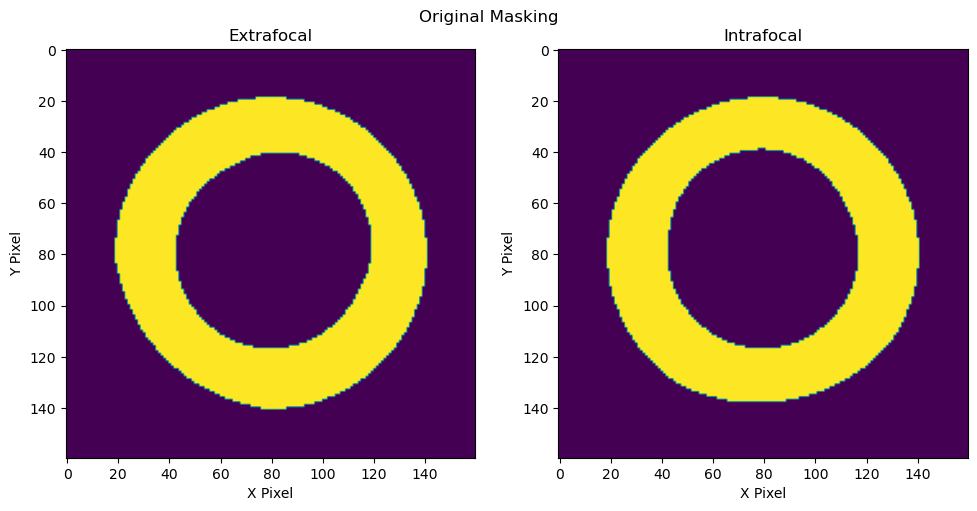

In [41]:
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(extra_img.mask_pupil)
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.title('Extrafocal')
fig.add_subplot(1, 2, 2)
plt.imshow(intra_img.mask_pupil)
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.title('Intrafocal')
plt.suptitle('Original Masking')
plt.tight_layout()

In [42]:
extra_img.makeBlendedMask(inst, model, boundaryT, maskScalingFactorLocal)
intra_img.makeBlendedMask(inst, model, boundaryT, maskScalingFactorLocal)

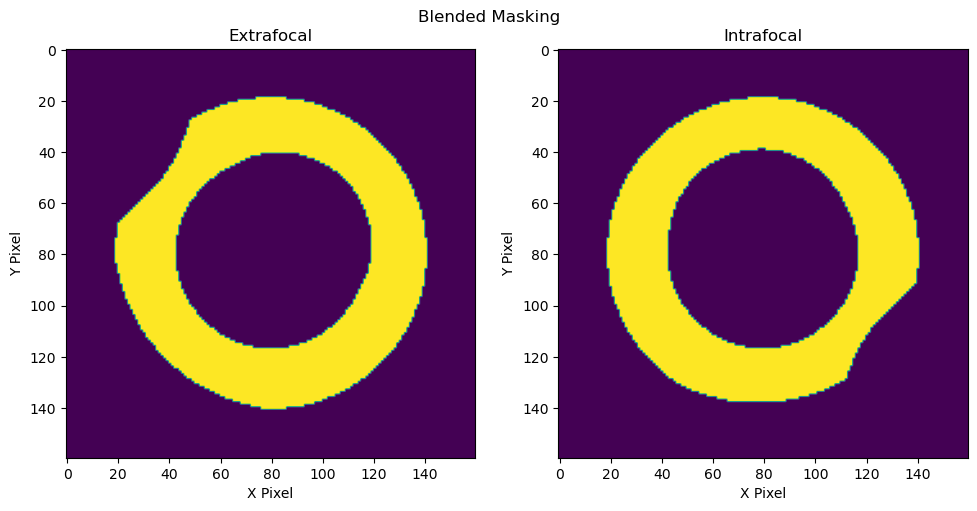

In [43]:
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(extra_img.mask_pupil)
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.title('Extrafocal')
fig.add_subplot(1, 2, 2)
plt.imshow(intra_img.mask_pupil)
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.title('Intrafocal')
plt.suptitle('Blended Masking')
plt.tight_layout()

### Run the algorithm

In [44]:
expAlgo.runIt(I1=intra_img, I2=extra_img, model=model, tol=1e-4)

itr = 0, z4-z22
[-207.  507.   45.   49. 1022.  -96.  -15.    9.  -22.  -95.   -7.  -82.
 -163.   17.   -9.   61.   15.  -49.   17.]
itr = 1, z4-z22
[-3.110e+02  4.600e+02  1.800e+01  7.000e+00  1.067e+03 -1.460e+02
 -8.000e+00  1.400e+01 -1.000e+01 -9.000e+01  1.000e+00 -8.500e+01
 -1.710e+02  2.700e+01 -1.400e+01  6.700e+01  1.900e+01 -6.100e+01
  1.500e+01]
itr = 2, z4-z22
[-3.910e+02  4.540e+02  6.200e+01  2.600e+01  1.045e+03 -1.480e+02
 -1.000e+01  1.200e+01 -1.300e+01 -8.900e+01 -1.000e+00 -7.900e+01
 -1.650e+02  2.100e+01 -1.400e+01  6.900e+01  1.400e+01 -6.300e+01
  1.400e+01]
itr = 3, z4-z22
[-4.58e+02  5.90e+02  1.07e+02  4.70e+01  1.02e+03 -1.59e+02 -8.00e+00
  1.00e+01 -1.30e+01 -7.50e+01  1.00e+00 -7.40e+01 -1.58e+02  1.50e+01
 -1.30e+01  7.10e+01  9.00e+00 -5.80e+01  1.30e+01]
itr = 4, z4-z22
[-513.  691.  144.   60. 1006. -167.   -8.    8.  -12.  -67.    6.  -68.
 -154.   10.  -12.   73.    3.  -55.   12.]
itr = 5, z4-z22
[-547.   51.  305.  156.   37. -286.  117.    9.

### Note on Final Combined Masks

Let's look at the final compensated images below. 

Notice that even though there is only one blended star notice that the masks must take out a chunk of the donut on each side.

This is because in the intra and extra-focal images the star is on the same side of the central star when we view it on the focal plane (see the donut stamps at the beginning of the notebook). But because we want to line up the light from the same locations on the mirror we must rotate the extra-focal image by 180 degrees. This means the star now ends up on the opposite side of the images used in the TIE calculation so we must mask it on each side of the donut.

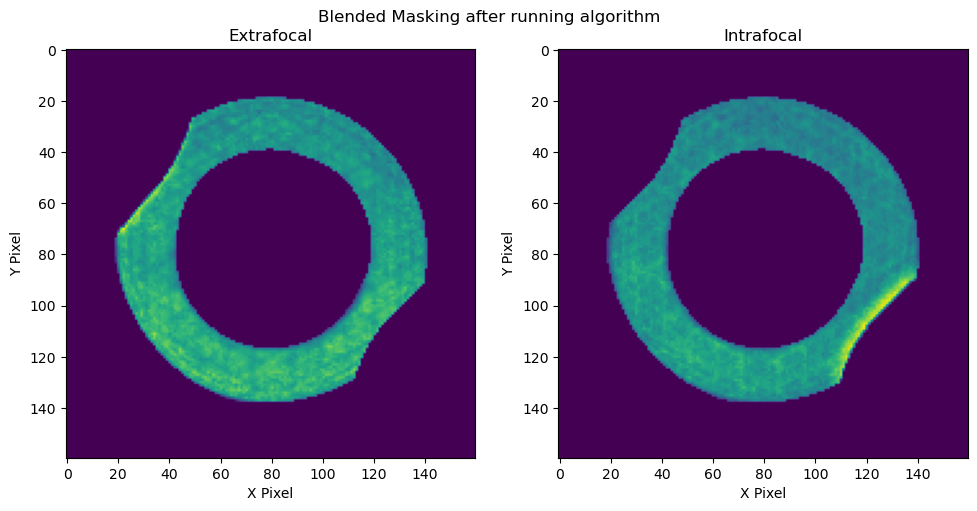

In [45]:
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(extra_img.mask_pupil*extra_img.getImg())
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.title('Extrafocal')
fig.add_subplot(1, 2, 2)
plt.imshow(intra_img.mask_pupil*intra_img.getImg())
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.title('Intrafocal')
plt.suptitle('Blended Masking after running algorithm')
plt.tight_layout()

In [46]:
algoLog = expAlgo.getHistory()

Text(0.5, 1.0, 'Combined Pupil Mask Used in Compensation')

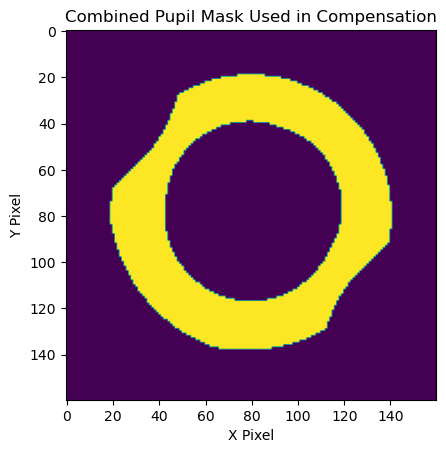

In [47]:
plt.imshow(algoLog[0]['pupilMask'])
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.title('Combined Pupil Mask Used in Compensation')

![source_selector_figure 1](notebook_figures/mask_rotate_1.jpg)

![source_selector_figure 1](notebook_figures/mask_rotate_2.jpg)

## Results

In [48]:
results_base_dir = 'testData/donutDeblending/v4_results/'

In [49]:
results_output_dirs = os.listdir(results_base_dir)

In [50]:
cwfs_list = list()
comcam_list = list()
for dir_name in results_output_dirs:
    if dir_name.startswith('comcam'):
        comcam_list.append(dir_name)
    elif dir_name.startswith('cwfs'):
        cwfs_list.append(dir_name)

In [63]:
comcam_pssn_results = list()
comcam_fwhm_results = list()
comcam_dist = list()
num_iters = 10
for dir_name in comcam_list:
    comcam_dist.append(float(dir_name.split('_')[1]))
    pssn_results = list()
    fwhm_results = list()
    for i in range(num_iters):
        loop_results = np.genfromtxt(os.path.join(results_base_dir, dir_name, f'iter{i}', 'img', 'PSSN.txt'))
        pssn_results.append(loop_results[0][-1])
        fwhm_results.append(loop_results[1][-1])
    comcam_pssn_results.append(pssn_results)
    comcam_fwhm_results.append(fwhm_results)
dist_arg_sort = np.argsort(comcam_dist)

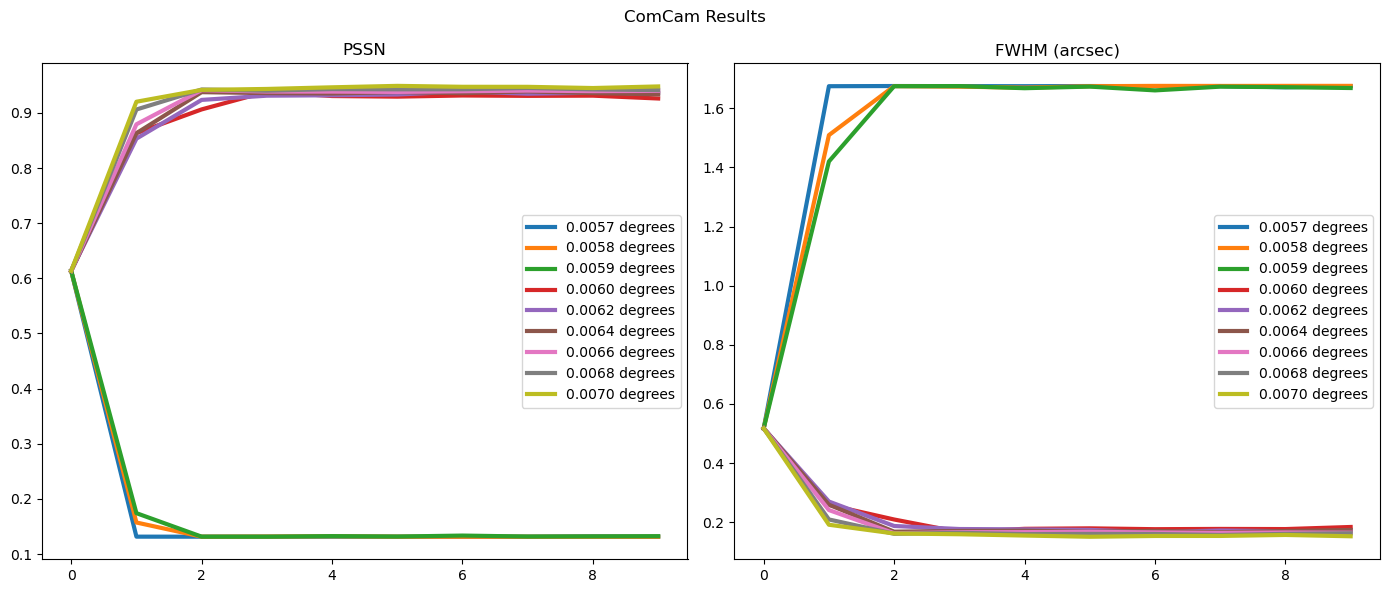

In [64]:
fig = plt.figure(figsize=(14, 6))
fig.add_subplot(1,2,1)
for idx in dist_arg_sort:
    dist = comcam_dist[idx]
    plt.plot(comcam_pssn_results[idx], lw=3, label=f'{dist*1e-4:.4f} degrees')
plt.legend()
plt.title('PSSN')
fig.add_subplot(1,2,2)
for idx in dist_arg_sort:
    dist = comcam_dist[idx]
    plt.plot(comcam_fwhm_results[idx], lw=3, label=f'{dist*1e-4:.4f} degrees')
plt.legend()
plt.title('FWHM (arcsec)')

plt.suptitle('ComCam Results')
plt.tight_layout()

In [65]:
cwfs_pssn_results = list()
cwfs_fwhm_results = list()
cwfs_dist = list()
num_iters = 10
for dir_name in cwfs_list:
    cwfs_dist.append(float(dir_name.split('_')[1]))
    pssn_results = list()
    fwhm_results = list()
    for i in range(num_iters):
        loop_results = np.genfromtxt(os.path.join(results_base_dir, dir_name, f'iter{i}', 'img', 'PSSN.txt'))
        pssn_results.append(loop_results[0][-1])
        fwhm_results.append(loop_results[1][-1])
    cwfs_pssn_results.append(pssn_results)
    cwfs_fwhm_results.append(fwhm_results)
dist_arg_sort = np.argsort(cwfs_dist)

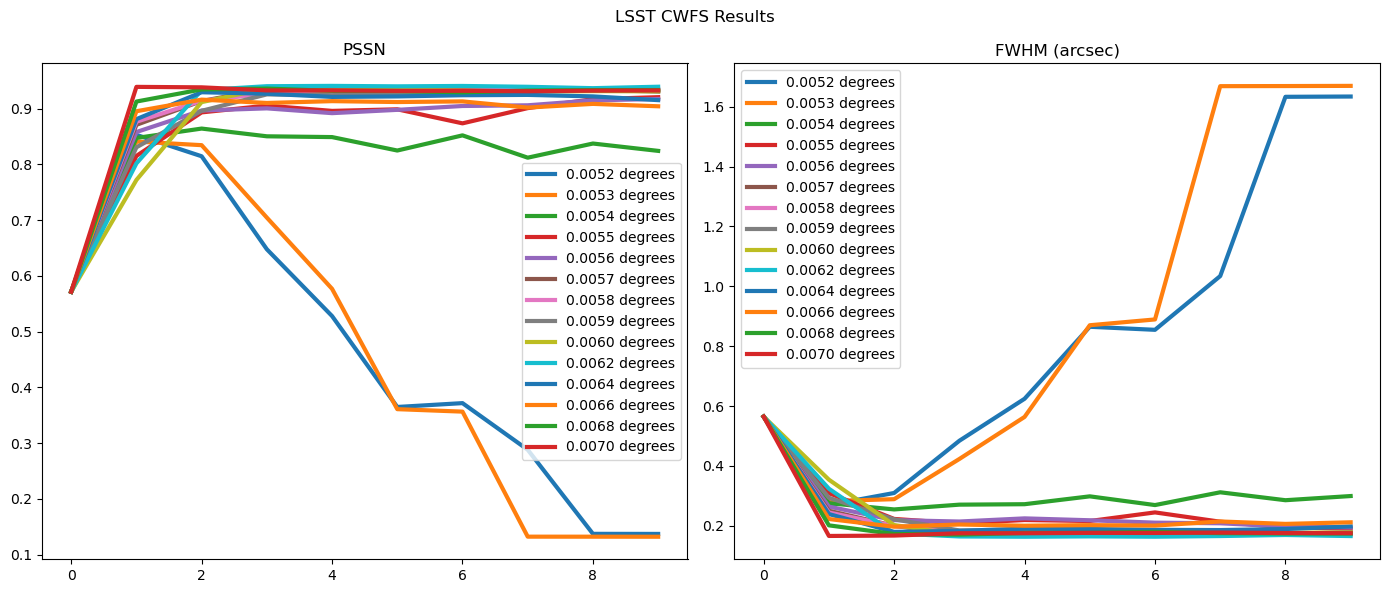

In [66]:
fig = plt.figure(figsize=(14, 6))
fig.add_subplot(1,2,1)
for idx in dist_arg_sort:
    dist = cwfs_dist[idx]
    plt.plot(cwfs_pssn_results[idx], lw=3, label=f'{dist*1e-4:.4f} degrees')
plt.legend()
plt.title('PSSN')
fig.add_subplot(1,2,2)
for idx in dist_arg_sort:
    dist = cwfs_dist[idx]
    plt.plot(cwfs_fwhm_results[idx], lw=3, label=f'{dist*1e-4:.4f} degrees')
plt.legend()
plt.title('FWHM (arcsec)')

plt.suptitle('LSST CWFS Results')
plt.tight_layout()